# PSEUDo vs. DTW: Gas Sensor Dataset

In this experiment we will compare the LSH algorithm of PSEUDo to DTW using a Gas Sensor dataset. The metrics we will be comparing these two algorithms with are **computing time**, **recall** and **precision**.

We first load the EEG data and convert it to a numpy array

In [1]:
import pandas as pd
import numpy as np
from time import time

datafile = 'data/ethylene_CO.txt'

data = pd.read_csv(datafile, sep='\s+', skiprows=1)
print(data.shape)

#and convert it to numpy array:
npdata = np.array(data.iloc[:, 3:], dtype = "float32")
del data

print(npdata.shape)
print(npdata.dtype)

(4208260, 19)
(4208260, 16)
float32


Next, the data is cut into subwindows of size T. We use a stepsize of T/8. Because of memory issues, only 40 of the 70 channels are used for this experiment.

In [2]:
from sklearn import preprocessing

N = 16
T = 200
M = 200000
data = np.array([preprocessing.minmax_scale(npdata[i:i+T, 0:N]) for i in range(0, npdata.shape[0]-T, int(npdata.shape[0]/M))])
del npdata
print(data.shape)

(200384, 200, 16)


We sample a number of subwindows which will be used as query for the search algorithms

In [3]:
import random

targets = random.sample(list(range(30000)), 10)
print(targets)

[25466, 18384, 13484, 2796, 28648, 7853, 23637, 18900, 19626, 18695]


## SAX

In [4]:
# from tslearn.piecewise import SymbolicAggregateApproximation

# t0 = time()
# sax = SymbolicAggregateApproximation(n_segments=T, alphabet_size_avg=10)
# sax_data = sax.fit_transform(data)
# print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
# sax_preprocess_time = time() - t0

In [5]:
# t0 = time()
# all_sax_candidates = []
# for i, target in enumerate(targets):
#     t1 = time()
#     query = sax_data[target]
#     sax_distances = [np.linalg.norm(query - window) for window in sax_data]
#     print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
#     sax_candidates = sorted(range(len(sax_distances)), key=lambda k: sax_distances[k])
#     all_sax_candidates.append(sax_candidates)
# sax_time = time() - t0

## PSEUDo

For the LSH algorithm some preprocessing is done to find the right LSH parameters.

In [6]:
import sys

sys.path.insert(0, '../Flaskserver')
import importlib
from pseudo import preprocess
import _lsh

topk_dtw = []

print('Preprocessing:')
t0 = time()
r,a,sd = preprocess(data, data.shape[2])
print('Preprocessing done. Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
pseudo_preprocess_time = time()-t0

Preprocessing:
r = 16
smaller
r = 8.0
bigger
r = 12.0
bigger
r = 14.0
bigger
r = 15.0
Mean: 15.727620185789746
Stdev: 1.8628273420697419
Ratio mean: 0.9598252437644486
Ratio stdev: 0.024943053588953483
Theta: 10.921525643249812
r: 1.0664384632349795
Preprocessing time: 16.362685441970825
Preprocessing done. Took 16.36 seconds (0.3 minutes).


Now we run the LSH algorithm for all targets and calculate the most similar subwindows

In [7]:
from collections import defaultdict
t0 = time()
total_lsh_times = []
all_lsh_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 0)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 28.71 seconds (0.5 minutes).
doing lsh
Target #1 done! Took 13.85 seconds (0.2 minutes).
doing lsh
Target #2 done! Took 33.40 seconds (0.6 minutes).
doing lsh
Target #3 done! Took 36.86 seconds (0.6 minutes).
doing lsh
Target #4 done! Took 21.58 seconds (0.4 minutes).
doing lsh
Target #5 done! Took 36.76 seconds (0.6 minutes).
doing lsh
Target #6 done! Took 31.50 seconds (0.5 minutes).
doing lsh
Target #7 done! Took 37.80 seconds (0.6 minutes).
doing lsh
Target #8 done! Took 34.46 seconds (0.6 minutes).
doing lsh
Target #9 done! Took 35.40 seconds (0.6 minutes).
Done! Took 310.30 seconds (5.2 minutes).


In [8]:
from collections import defaultdict
t0 = time()
total_lsh_times_ed = []
all_lsh_candidates_ed = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 1)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times_ed.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates_ed.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 14.30 seconds (0.2 minutes).
doing lsh
Target #1 done! Took 8.51 seconds (0.1 minutes).
doing lsh
Target #2 done! Took 11.47 seconds (0.2 minutes).
doing lsh
Target #3 done! Took 12.14 seconds (0.2 minutes).
doing lsh
Target #4 done! Took 9.91 seconds (0.2 minutes).
doing lsh
Target #5 done! Took 11.43 seconds (0.2 minutes).
doing lsh
Target #6 done! Took 13.37 seconds (0.2 minutes).
doing lsh
Target #7 done! Took 12.90 seconds (0.2 minutes).
doing lsh
Target #8 done! Took 8.63 seconds (0.1 minutes).
doing lsh
Target #9 done! Took 12.22 seconds (0.2 minutes).
Done! Took 114.90 seconds (1.9 minutes).


## DTW

In [9]:
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw_path_from_metric
from tslearn.metrics import dtw
from time import time

t0 = time()
total_dtw_times = []
all_dtw_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    dtw_distances = [dtw(window, query, global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * T)) for window in data]
    dtw_candidates = sorted(range(len(dtw_distances)), key=lambda k: dtw_distances[k])
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    total_dtw_times.append(time()-t1)
    all_dtw_candidates.append(dtw_candidates)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 64.44 seconds (1.1 minutes).
Target #1 done! Took 64.55 seconds (1.1 minutes).
Target #2 done! Took 64.49 seconds (1.1 minutes).
Target #3 done! Took 64.77 seconds (1.1 minutes).
Target #4 done! Took 64.28 seconds (1.1 minutes).
Target #5 done! Took 64.40 seconds (1.1 minutes).
Target #6 done! Took 64.28 seconds (1.1 minutes).
Target #7 done! Took 65.18 seconds (1.1 minutes).
Target #8 done! Took 67.57 seconds (1.1 minutes).
Target #9 done! Took 64.41 seconds (1.1 minutes).
Done! Took 648.36 seconds (10.8 minutes).


## ED

In [10]:
t0 = time()
all_ed_candidates = []
total_ed_times = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    ed_distances = [np.linalg.norm(query-window) for window in data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    ed_candidates = sorted(range(len(ed_distances)), key=lambda k: ed_distances[k])
    total_ed_times.append(time()-t1)
    all_ed_candidates.append(ed_candidates)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 1.51 seconds (0.0 minutes).
Target #1 done! Took 1.50 seconds (0.0 minutes).
Target #2 done! Took 1.48 seconds (0.0 minutes).
Target #3 done! Took 1.45 seconds (0.0 minutes).
Target #4 done! Took 1.46 seconds (0.0 minutes).
Target #5 done! Took 1.46 seconds (0.0 minutes).
Target #6 done! Took 1.47 seconds (0.0 minutes).
Target #7 done! Took 1.47 seconds (0.0 minutes).
Target #8 done! Took 1.48 seconds (0.0 minutes).
Target #9 done! Took 1.47 seconds (0.0 minutes).
Done! Took 15.81 seconds (0.3 minutes).


## Accuracy comparison

We compare the PSEUDo candidates to the DTW candidates and test on recall, precision and number of pruned candidates

In [11]:
k = 100
total_recall_pseudo = []
total_precision_pseudo = []
total_precision2_pseudo = []
total_pruned_pseudo = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo.append(pruned)
    total_recall_pseudo.append(recall/k)
    total_precision_pseudo.append(precision/k)
    total_precision2_pseudo.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo)) + "%")

Total pruned: 20.1%
Total recall: 99.69999999999999%
Total precision: 25.0%
Total precision 2: 96.8%


In [12]:
total_recall_pseudo_ed = []
total_precision_pseudo_ed = []
total_precision2_pseudo_ed = []
total_pruned_pseudo_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates_ed[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates_ed[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates_ed[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates_ed[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates_ed[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo_ed.append(pruned)
    total_recall_pseudo_ed.append(recall/k)
    total_precision_pseudo_ed.append(precision/k)
    total_precision2_pseudo_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo_ed)) + "%")

Total pruned: 32.9%
Total recall: 92.4%
Total precision: 18.0%
Total precision 2: 79.3%


For validation we also test the recall and precision of the ED candidates copmared to the DTW candidates

In [13]:
total_recall_ed = []
total_precision_ed = []
total_precision2_ed = []
total_pruned_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_ed_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_ed_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_ed_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_ed_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_ed_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_ed.append(pruned)
    total_recall_ed.append(recall/k)
    total_precision_ed.append(precision/k)
    total_precision2_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_ed)) + "%")

Total pruned: 0.0%
Total recall: 100.0%
Total precision: 44.9%
Total precision 2: 99.8%


In [14]:
# total_recall_sax = []
# total_precision_sax = []
# total_precision2_sax = []
# total_pruned_sax = []
# for i in range(len(targets)):
#     top_10_percent = int(len(all_sax_candidates[i]) * 0.1)
#     pruned = int(100*(1-len(all_sax_candidates[i])/len(all_dtw_candidates[i])))
# #     print("Pruned: " + str(pruned) + "%")
#     recall = 0
#     for index in all_dtw_candidates[i][0:k]:
#         if index in all_sax_candidates[i]:
#             recall += 1
# #     print("Recall: " + str(100*recall/k) + "%")

#     precision = 0
#     for index in all_dtw_candidates[i][0:k]:
#         if index in all_sax_candidates[i][0:k]:
#             precision += 1
# #     print("Precision: " + str(100*precision/k) + "%")
    
#     precision2 = 0
#     for index in all_sax_candidates[i][0:k]:
#         if index in all_dtw_candidates[i][0:top_10_percent]:
#             precision2 += 1
# #     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
#     total_pruned_sax.append(pruned)
#     total_recall_sax.append(recall/k)
#     total_precision_sax.append(precision/k)
#     total_precision2_sax.append(precision2/k)
    
# print("=================================================")
# print("Total pruned: " + str(np.mean(total_pruned_sax)) + "%")
# print("Total recall: " + str(100 * np.mean(total_recall_sax)) + "%")
# print("Total precision: " + str(100 * np.mean(total_precision_sax)) + "%")
# print("Total precision 2: " + str(100 *np.mean(total_precision2_sax)) + "%")

Here we plot the results of the precision and recall

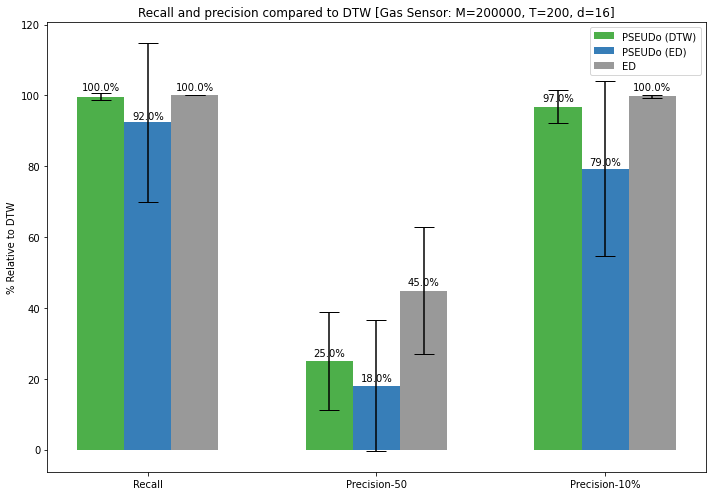

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Recall', 'Precision-50', 'Precision-10%']
pseudo_values = [
    100 * np.mean(total_recall_pseudo), 
    100 * np.mean(total_precision_pseudo), 
    100 * np.mean(total_precision2_pseudo)
]
pseudo_error = [
    100 * np.std(total_recall_pseudo), 
    100 * np.std(total_precision_pseudo), 
    100 * np.std(total_precision2_pseudo)
]
pseudo_ed_values = [
    100 * np.mean(total_recall_pseudo_ed), 
    100 * np.mean(total_precision_pseudo_ed), 
    100 * np.mean(total_precision2_pseudo_ed)
]
pseudo_ed_error = [
    100 * np.std(total_recall_pseudo_ed), 
    100 * np.std(total_precision_pseudo_ed), 
    100 * np.std(total_precision2_pseudo_ed)
]
ed_values = [
    100 * np.mean(total_recall_ed), 
    100 * np.mean(total_precision_ed), 
    100 * np.mean(total_precision2_ed)
]
ed_error = [
    100 * np.std(total_recall_ed), 
    100 * np.std(total_precision_ed), 
    100 * np.std(total_precision2_ed)
]

colors = ['#4daf4a', '#377eb8', '#ff7f00',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

x = 1.7 * np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width, pseudo_values, width, yerr=pseudo_error, color=colors[0], capsize=10, label='PSEUDo (DTW)')
rects2 = ax.bar(x, pseudo_ed_values, width, yerr=pseudo_ed_error, color=colors[1], capsize=10, label='PSEUDo (ED)')
rects3 = ax.bar(x + width, ed_values, width, yerr=ed_error, color=colors[6], capsize=10, label='ED')

ax.set_ylabel('% Relative to DTW')
ax.set_title('Recall and precision compared to DTW [Gas Sensor: M={}, T={}, d={}]'.format(M, T, N))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),0)
        ax.annotate('{}'.format(height)+'%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('images/accuracy_gas_' + str(M) + '_' + str(T) +'_' + str(N))
plt.show()

## Computing time

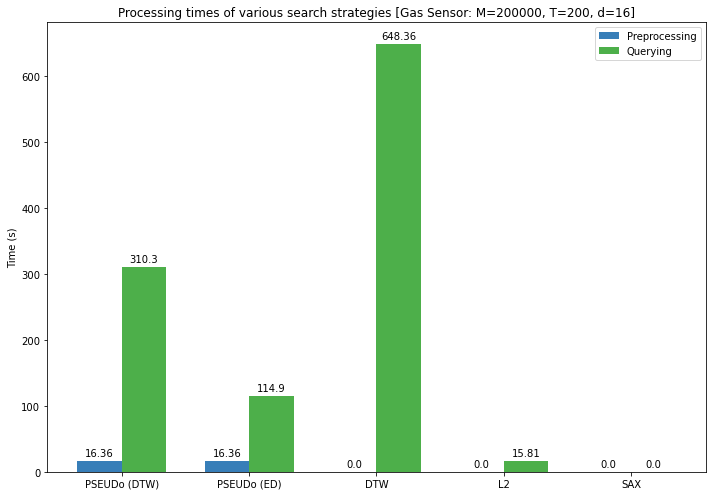

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['PSEUDo (DTW)', 'PSEUDo (ED)', 'DTW', 'L2', 'SAX']
preprocess_vales = [pseudo_preprocess_time, pseudo_preprocess_time, 0, 0, 0]
query_values = [np.sum(total_lsh_times), np.sum(total_lsh_times_ed), np.sum(total_dtw_times), np.sum(total_ed_times), 0]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width/2, preprocess_vales, width, color=colors[1], label='Preprocessing')
rects2 = ax.bar(x + width/2, query_values, width, color=colors[0], label='Querying')

ax.set_ylabel('Time (s)')
ax.set_title('Processing times of various search strategies [Gas Sensor: M={}, T={}, d={}]'.format(M, T, N))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('images/time_gas_' + str(M) + '_' + str(T) +'_' + str(N))

plt.show()

In [17]:
import json

sax_values=[0,0,0]

with open("results.json", "r") as jsonFile:
    data = json.load(jsonFile)
    
result_dict = {
    'pseudo_values': pseudo_values,
    'pseudo_ed_values': pseudo_ed_values,
    'ed_values': ed_values,
    'sax_values': sax_values,
    'preprocess_values': preprocess_vales,
    'query_values': query_values
}

data["query4"] = result_dict
with open("results.json", "w") as jsonFile:
    json.dump(data, jsonFile, indent=4)